In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize
# import inspect
import itertools

# Warm up
Consider the function $f (x, y) = e^x e^y$. Approximate this function on $X = [0, 1] \times [−1, 0]$ using the projection algorithm discussed in class (use collocation with Chebyshev polynomials). Now approximate the function $g(x) = \max \{0, x − 1 \}$ on $X = [0, 2]$ using the same algorithm. Consider $n = p = 3$, $n = p = 5$, $n = p = 10$, $n = p = 20$. Plot these four approximations as a function of $x$, along with the true function.

In [59]:
def multi_chebyshev_nodes(parameters):
    n_nodes = [row[1] for row in parameters]
    # n_nodes = [np.arange(1,x+1) for x in n_nodes]
    n_nodes = [list(range(1, x+1)) for x in n_nodes]
    iterations = list(itertools.product(*n_nodes)) # all possible combination of nodes (n_1) x (n_2) x (n_3) ...

    n_p = [row[0] for row in parameters]
    n_p = [x + 1 for x in n_p]
    p_prod = np.prod(n_p) # (p_1+1) x (p_2+1) x (p_3+1) ...

    T_nodes = np.zeros((len(iterations),p_prod))

    nodes = []
    # for each combination of nodes
    for index,it in enumerate(iterations):
        # T_i = np.zeros((len(it),parameters[index1][0]+1)) # it should be dim x (p+1)
        T_ii = []
        # nodes_i = np.zeros(len(it))
        nodes_i = [0] * len(it)
        for index1,i in enumerate(it):
            nodes_i[index1] = np.cos((2*i - 1) * np.pi / (2*parameters[index1][1]))
            # define the chebyshev polinomials
            T_i = np.zeros(parameters[index1][0]+1)
            T_i[0] = 1
            T_i[1] = nodes_i[index1]
            for j in range(1,parameters[index1][0]):
                T_i[j+1] = 2 * nodes_i[index1] * T_i[j] - T_i[j-1]
            T_ii.append(T_i)
        nodes.append(nodes_i)
        combinations = itertools.product(*T_ii)
        T_nodes[index,:] = [np.prod(combination) for combination in combinations]
    nodes = np.array(nodes).T
    return nodes, T_nodes, p_prod

# change variable from x (argument in the polinomials) to b (argument in the actual function) for each combinations
def x_to_bs(nodes,intervals):
    bs = nodes
    for index, int in enumerate(intervals):
        # bs[index] = x_to_b(nodes[index], int[0], int[1])
        bs[index] = (nodes[index]+1)*(int[1]-int[0])/2 + int[0]
    return bs

# change variable from b (argument in the actual function) to x (argument in the polinomials)
def b_to_x(b, b_max, b_min):
    return (2*b)/(b_max-b_min)-(b_max+b_min)/(b_max-b_min)

def sse(gamma, fun, b, T):
    fun=fun(*b) 
    R = fun - T @ gamma
    return np.sum(R**2)

def get_gamma(fun, intervals, parameters):
    # compute the nodes and the Chebyshev polinomials in the nodes
    nodes, T_nodes, p_prod = multi_chebyshev_nodes(parameters)
    # compute weights that minimize the sum of squared residuals
    bs = x_to_bs(nodes,intervals)
    res = optimize.minimize(sse, x0=np.zeros(p_prod), args=(fun, bs, T_nodes))
    gamma = res.x
    return gamma    

def get_approx(fun,intervals,parameters):
    gamma = get_gamma(fun,intervals,parameters)
    def approx_fun(*args):
            T_ii = []
            for index, arg in enumerate(args):
                # arg = arg.reshape((10000,1))
                try:
                    length = len(arg)
                except:
                    length = 1
                x = (2*arg)/(intervals[index][1]-intervals[index][0])-(intervals[index][1]+intervals[index][0])/(intervals[index][1]-intervals[index][0])
                T_i = np.zeros((length,parameters[index][0]+1))
                T_i[:,0] = np.ones((length,1)).T
                T_i[:,1] = x.T
                for j in range(1,parameters[index][0]):
                    T_i[:,j+1] = 2 * x * T_i[:,j] - T_i[:,j-1]
                T_ii.append(T_i)
            num_combinations = 1
            for matrix in T_ii:
                num_combinations *= len(matrix)
            n_p = [row[0] for row in parameters]
            n_p = [x + 1 for x in n_p]
            p_prod = np.prod(n_p)
            T = np.zeros((num_combinations,p_prod))
            for index1,row_comb in enumerate(itertools.product(*T_ii)):
                for index2,prod in enumerate(itertools.product(*row_comb)):
                  T[index1,index2] = np.prod(prod)
            result = T @ gamma
            # return result.reshape((100, 100))
            return result
    return approx_fun


In [61]:
def f(x, y):
    return np.exp(x) * np.exp(y)

# Define the grid
num_points = 100

intervals = [[0, 1], 
             [-1, 0]]

parameters = [[3, 3], 
              [3, 3]]

approx_f = get_approx(f,intervals,parameters)

num_points = 100
x_min, x_max = 0, 1
y_min, y_max = -1, 0
x_grid = np.linspace(x_min, x_max, 100)
y_grid = np.linspace(y_min, y_max, 100)

for x in x_grid:
    for y in y_grid:
        z = f(x,y)
        z_app = approx_f(x,y)
        print(z,z_app)


# # Define the grid
# num_points = 100
# x_min, x_max = 0, 1
# y_min, y_max = -1, 0
# x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# # Evaluate the function on the grid
# z_grid = f(x_grid, y_grid)

# approx_f = get_approx(f,[[0,1],[-1,0]],[[3,3],[3,3]])
# # Evaluate the approximate function on the grid
# z_grid_approx = approx_f(x_grid, y_grid)

# # Plot the surface
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(x_grid, y_grid, z_grid)
# ax.plot_surface(x_grid, y_grid, z_grid_approx)
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('f(x,y)')
# plt.show()
# plt.close()

0.36787944117144233 [0.37355737]
0.37161422591680865 [0.37682207]
0.3753869269345544 [0.38015012]
0.3791979291581653 [0.3835415]
0.38304762142904825 [0.38699622]
0.38693639653620454 [0.39051429]
0.39086465125630715 [0.3940957]
0.3948327863941843 [0.39774044]
0.3988412068237137 [0.40144853]
0.402890321529133 [0.40521996]
0.4069805436467683 [0.40905473]
0.41111229050718745 [0.41295284]
0.4152859836777806 [0.4169143]
0.4195020490057732 [0.42093909]
0.4237609166616761 [0.42502723]
0.4280630211831759 [0.4291787]
0.43240880151947175 [0.43339352]
0.43679870107606167 [0.43767168]
0.441233167759984 [0.44201317]
0.44571265402551763 [0.44641801]
0.4502376169203467 [0.4508862]
0.4548085181321939 [0.45541772]
0.45942582403592663 [0.46001258]
0.4640900057411421 [0.46467078]
0.4688015391402353 [0.46939233]
0.4735609049569548 [0.47417722]
0.4783685887954514 [0.47902544]
0.48322508118982543 [0.48393701]
0.4881308776541762 [0.48891192]
0.4930864787331598 [0.49395017]
0.4980923900530609 [0.49905176]
0.50

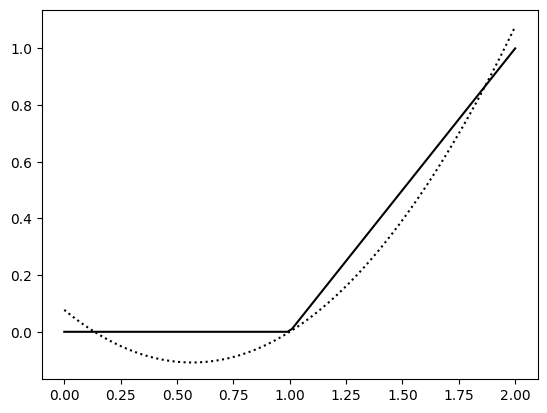

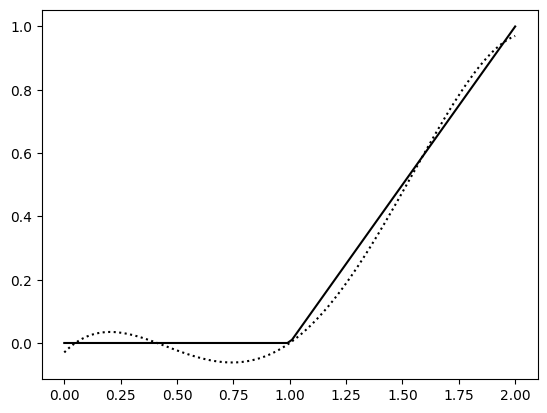

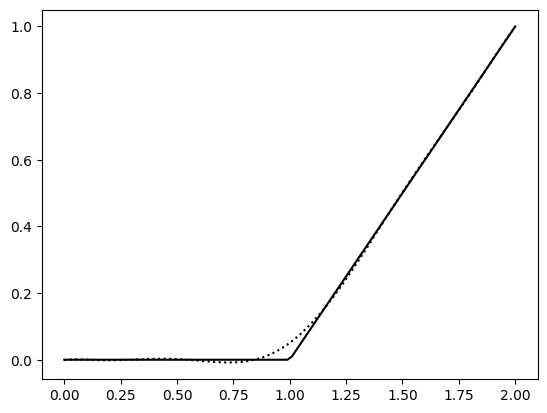

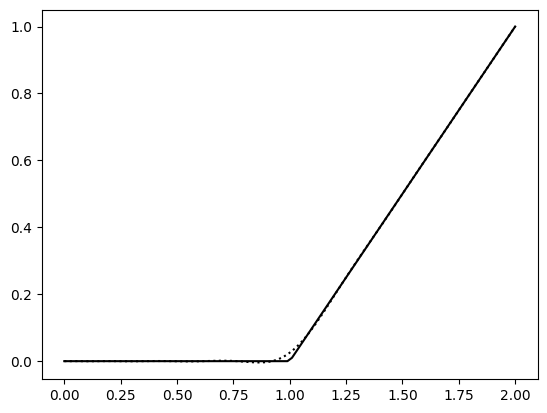

In [65]:
def g(x):
    return np.maximum(0, x - 1)

# Define the interval of the function
intervals = [[0, 2]]

# Define the grid
num_points = 100

# grid
b_grid = np.linspace(0,2,num_points)
y_grid = g(b_grid)

# Define the degrees of the Chebyshev polynomials
parameters = [[3,3], [5,5], [10,10], [20,20]]

gs = []
# Compute the approximations
for i, par in enumerate(parameters):
    app_g = get_approx(g,intervals,[par])
    gs.append(app_g)


for g in gs: 
    # fig, axs = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
    y_app_grid = g(b_grid)
    fig = plt.figure()
    plt.plot(b_grid,y_grid, 'k-')
    plt.plot(b_grid,y_app_grid, 'k:')
    plt.show()
    plt.close()